# kelompok 3
* Fatyhatul Husna         122120041
* Gilbert Timothy Sihar   122120074
* Anwar Udin Sayfulloh    122120144
* Dafa Bilhaqi            122120182

## Import LIBRARY

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os, shutil, random
from PIL import Image
import torchvision.models as models

## DATA CLONE

In [ ]:
#!git clone https://github.com/ipul122/rock_data_for_DL.git

In [ ]:
rm -rf rock_data_for_DL/.git

## Split

In [ ]:
source = "rock_data_for_DL"
output = "dataset_split"

os.makedirs(f"{output}/train", exist_ok=True)
os.makedirs(f"{output}/test", exist_ok=True)

for cls in os.listdir(source):
    cls_path = os.path.join(source, cls)
    if not os.path.isdir(cls_path):
        continue

    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(("png","jpg","jpeg"))]
    random.shuffle(imgs)

    split = int(0.75 * len(imgs))
    # 75 : 25
    train, test = imgs[:split], imgs[split:]

    # buat folder class
    os.makedirs(f"{output}/train/{cls}", exist_ok=True)
    os.makedirs(f"{output}/test/{cls}", exist_ok=True)

    for f in train:
        shutil.copyfile(os.path.join(cls_path, f), f"{output}/train/{cls}/{f}")

    for f in test:
        shutil.copyfile(os.path.join(cls_path, f), f"{output}/test/{cls}/{f}")

    print(cls, "| Train:", len(train), "| Test:", len(test))

print("\nDONE!")

Pumice | Train: 35 | Test: 12
Slate | Train: 37 | Test: 13
Carbonatite | Train: 33 | Test: 11
Porphyry | Train: 34 | Test: 12
Siltstone | Train: 22 | Test: 8
Sandstone | Train: 43 | Test: 15
Travertine | Train: 40 | Test: 14
Shale | Train: 27 | Test: 10
Blueschist | Train: 24 | Test: 8
Flint | Train: 40 | Test: 14
Anthracite | Train: 33 | Test: 11
Dolomite | Train: 43 | Test: 15
Gneiss | Train: 36 | Test: 13
Oolite | Train: 30 | Test: 10
Evaporite | Train: 36 | Test: 12
Basalt | Train: 37 | Test: 13
Quartz_diorite | Train: 33 | Test: 11
Breccia | Train: 24 | Test: 8
Granulite | Train: 38 | Test: 13
Andesite | Train: 21 | Test: 7
Obsidian | Train: 41 | Test: 14
Oil_shale | Train: 27 | Test: 9
Mudstone | Train: 34 | Test: 12
Greenschist | Train: 33 | Test: 11
Serpentinite | Train: 31 | Test: 11
Komatiite | Train: 40 | Test: 14
Gabbro | Train: 25 | Test: 9
Amphibolite | Train: 27 | Test: 9
Marble | Train: 44 | Test: 15
Quartzolite | Train: 41 | Test: 14
Limestone | Train: 39 | Test: 13
Ho

## Augmentation

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])


## Dataloader

In [ ]:
train_ds = datasets.ImageFolder("dataset_split/train", transform=train_tfms)
test_ds  = datasets.ImageFolder("dataset_split/test",  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


## Show Train_ds

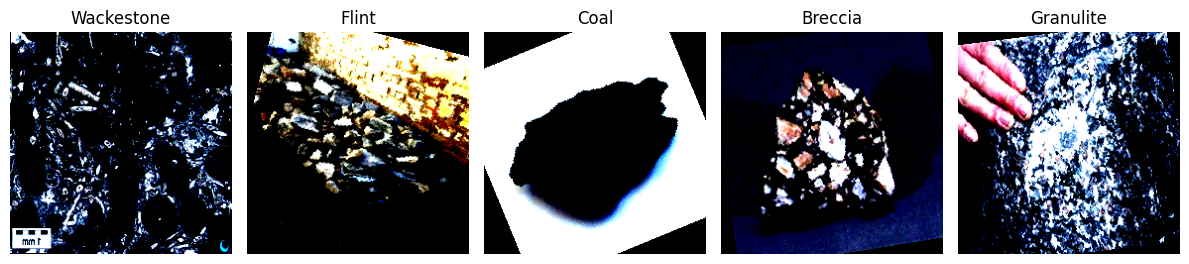

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].numpy().transpose(1,2,0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(train_ds.classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

## CNN ARCH

In [ ]:
num_classes = 53

model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
fc.weight
fc.bias


In [ ]:
print("Total parameters :", sum(p.numel() for p in model.parameters()))
print("Device :", device)

Total parameters : 21311861
Device : cuda


## Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

def train_one_epoch(model, loader):
    model.train()
    tl = 0
    ta = 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)
        loss.backward() # grad
        optimizer.step() # update

        tl+=loss.item() * x.size(0)
        ta+=accuracy(out, y) * x.size(0)

    return tl/len(loader.dataset), ta/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_acc  = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            total_acc  += accuracy(logits, y)

    return total_loss / len(loader), total_acc / len(loader)

## Checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/best_model"
os.makedirs(save_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_checkpoint(model, optimizer, epoch, best_acc, filename="best.pth"):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "best_acc": best_acc
    }

    save_path = f"/content/drive/MyDrive/best_model/{filename}"
    torch.save(checkpoint, save_path)

def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    best_acc = checkpoint["best_acc"]

    print(f"Checkpoint loaded — Resume from epoch {start_epoch}")
    return start_epoch, best_acc

## Train

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0
start_epoch = 1

In [ ]:
num_epochs = 20

for ep in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        save_checkpoint(model, optimizer, ep, best_acc, "best_model_resnet34.pth")

    print(f"[Epoch {ep}] " f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc*100:.2f}% | " f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc*100:.2f}%")

[Epoch 1] Train Loss: 0.2723  Train Acc: 89.42% | Val Loss: 0.6460  Val Acc: 86.95%


[Epoch 2] Train Loss: 0.1998  Train Acc: 91.37% | Val Loss: 0.6493  Val Acc: 87.04%


[Epoch 3] Train Loss: 0.1969  Train Acc: 91.05% | Val Loss: 0.6355  Val Acc: 86.86%


[Epoch 4] Train Loss: 0.1721  Train Acc: 91.83% | Val Loss: 0.6346  Val Acc: 86.67%


[Epoch 5] Train Loss: 0.1718  Train Acc: 91.87% | Val Loss: 0.6272  Val Acc: 87.41%


[Epoch 6] Train Loss: 0.1697  Train Acc: 91.92% | Val Loss: 0.6360  Val Acc: 87.22%


[Epoch 7] Train Loss: 0.1656  Train Acc: 91.60% | Val Loss: 0.6330  Val Acc: 86.76%


[Epoch 8] Train Loss: 0.1598  Train Acc: 91.78% | Val Loss: 0.6213  Val Acc: 86.67%


[Epoch 9] Train Loss: 0.1642  Train Acc: 92.01% | Val Loss: 0.6255  Val Acc: 86.76%


[Epoch 10] Train Loss: 0.1515  Train Acc: 92.42% | Val Loss: 0.6286  Val Acc: 86.49%


[Epoch 11] Train Loss: 0.1490  Train Acc: 91.96% | Val Loss: 0.6257  Val Acc: 86.76%


[Epoch 12] Train Loss: 0.1519  Train Acc: 92.42% | Val Loss: 0.6206  Val Acc: 86.86%


[Epoch 13] Train Loss: 0.1424  Train Acc: 92.14% | Val Loss: 0.6345  Val Acc: 86.49%


[Epoch 14] Train Loss: 0.1478  Train Acc: 92.37% | Val Loss: 0.6333  Val Acc: 86.67%


[Epoch 15] Train Loss: 0.1426  Train Acc: 92.73% | Val Loss: 0.6376  Val Acc: 87.04%


[Epoch 16] Train Loss: 0.1397  Train Acc: 92.42% | Val Loss: 0.6296  Val Acc: 86.76%


[Epoch 17] Train Loss: 0.1472  Train Acc: 92.19% | Val Loss: 0.6209  Val Acc: 87.13%


[Epoch 18] Train Loss: 0.1414  Train Acc: 91.92% | Val Loss: 0.6249  Val Acc: 87.59%


[Epoch 19] Train Loss: 0.1403  Train Acc: 92.23% | Val Loss: 0.6232  Val Acc: 86.95%


[Epoch 20] Train Loss: 0.1422  Train Acc: 92.42% | Val Loss: 0.6224  Val Acc: 87.13%


## Train Curve

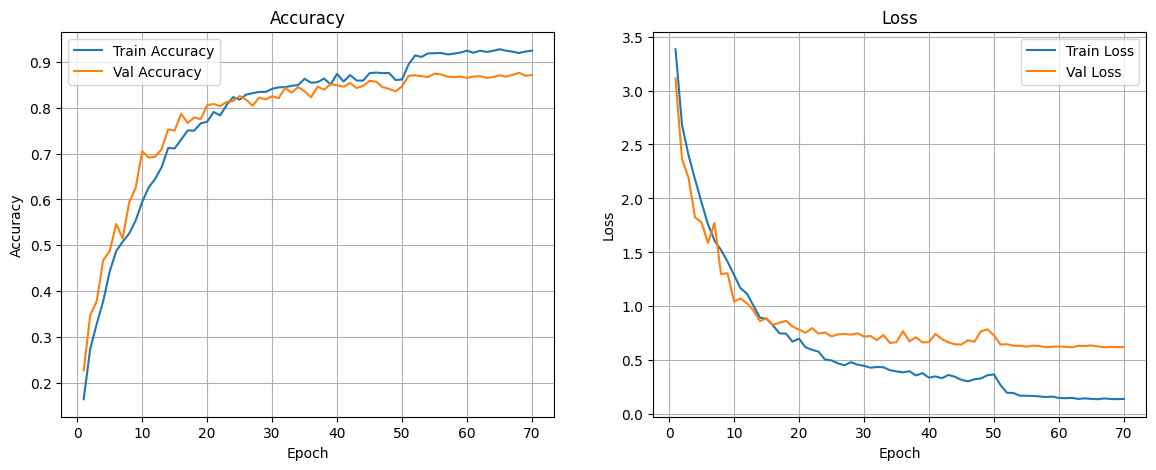

In [ ]:
epochs = range(1, num_epochs+1+50)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
save_checkpoint(model, optimizer, ep, best_acc, "model_RESNET.pth")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)  # (53, 53)


(53, 53)


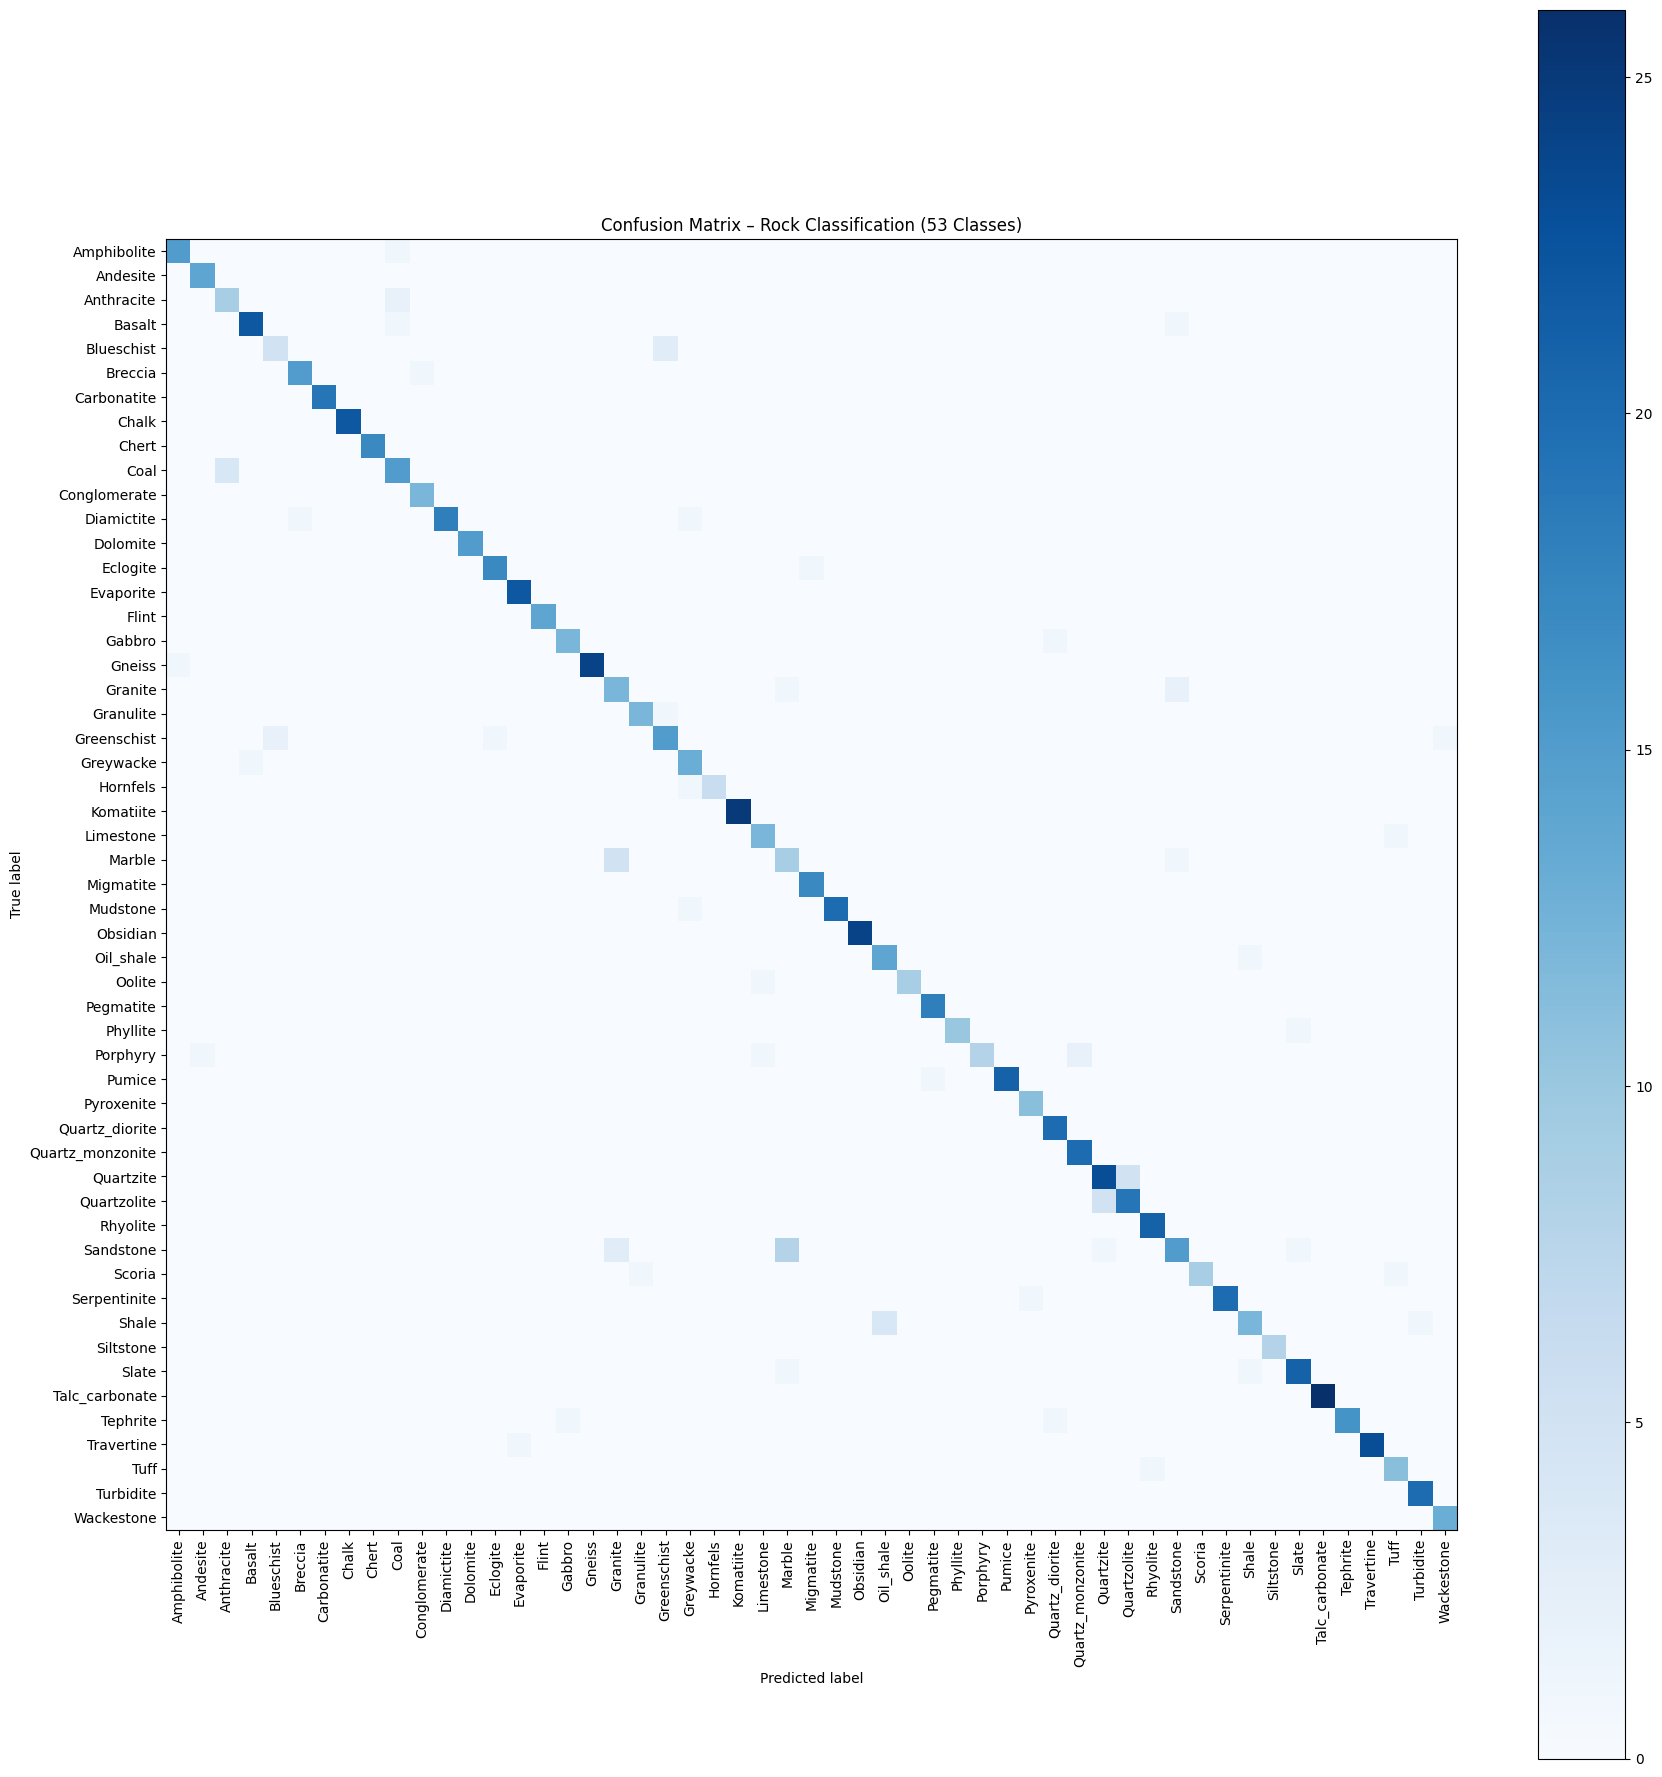

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=train_ds.classes
)

disp.plot(
    include_values=False,
    cmap="Blues",
    ax=ax,
    xticks_rotation=90
)

plt.title("Confusion Matrix – Rock Classification (53 Classes)")
plt.tight_layout()
plt.show()
